In [1]:
#! git clone https://github.com/angus924/rocket
#! git clone https://github.com/moisesrsantos/tsmorph-xai

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from models import Models
from morph import Morph
from generation import Generation

In [3]:
def getPCA(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

def getTSNE(X, n_components=2):
    tsne = TSNE(n_components=n_components)
    X_tsne = tsne.fit_transform(X)
    return X_tsne
    
def plot_components(X, y):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='viridis', alpha=0.7)
    plt.title('PCA Components', fontsize=14, pad=15)
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Class')
    plt.show()

## Example


In [4]:
gen = Generation(shift=0.08)
X, y = gen.generate_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

d:\UNI\L_IACD\3_Year\2_Semester\INV\Morphing\generation.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sample_{i+1}'] = final_signal
d:\UNI\L_IACD\3_Year\2_Semester\INV\Morphing\generation.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sample_{i+1}'] = final_signal


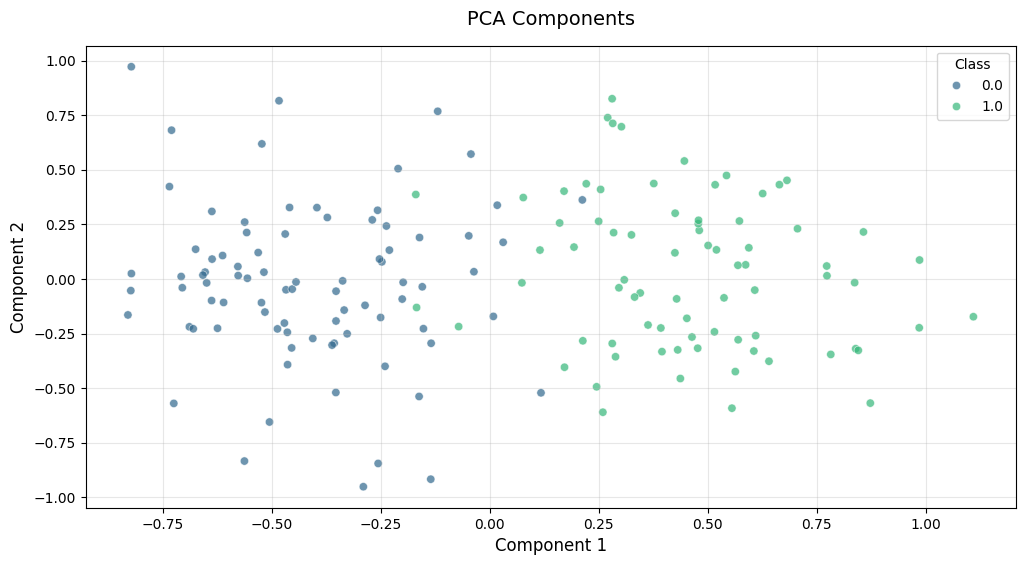

In [5]:
X_pca = getPCA(X_train.squeeze(axis=1), 2)
plot_components(X_pca, y_train)

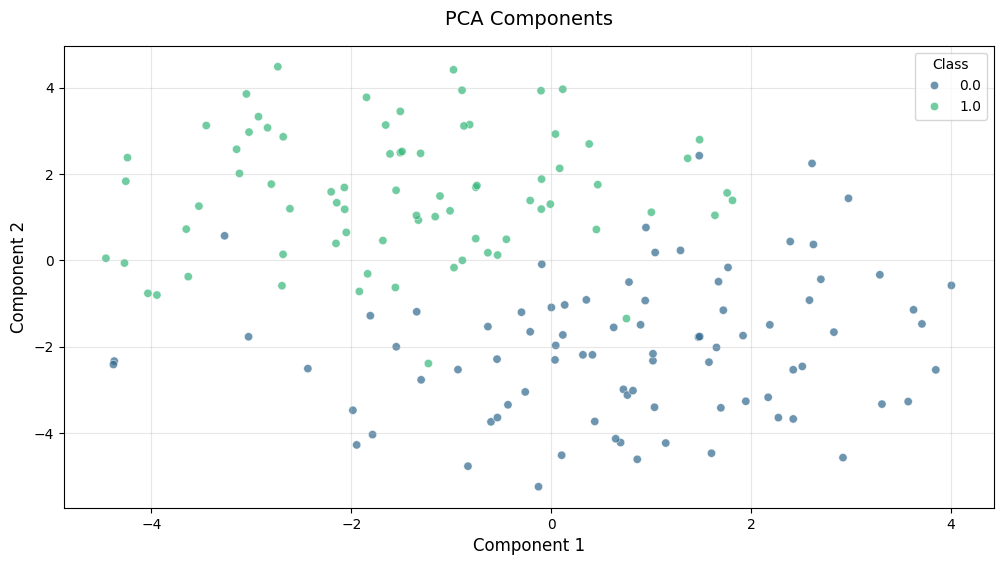

In [6]:
X_tsne = getTSNE(X_train.squeeze(axis=1), 2)
plot_components(X_tsne, y_train)

In [7]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(160, 1, 100) (40, 1, 100) (160,) (40,)


In [8]:
catch22 = Models('catch22', X_train, y_train)
catch22.train_catch22()

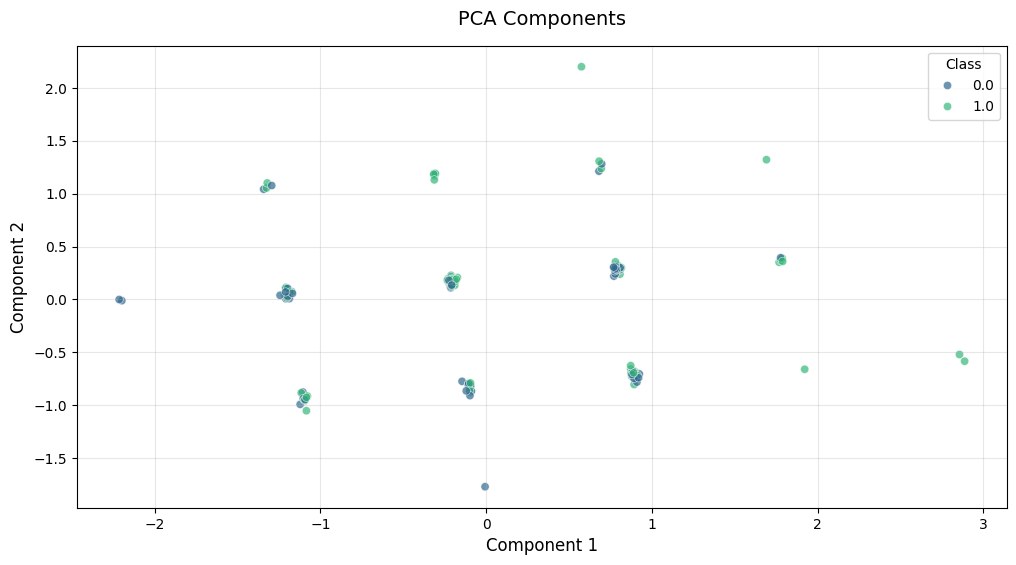

In [9]:
catch22_X_pca = getPCA(catch22.catch22_train, 2)
plot_components(catch22_X_pca, y_train)

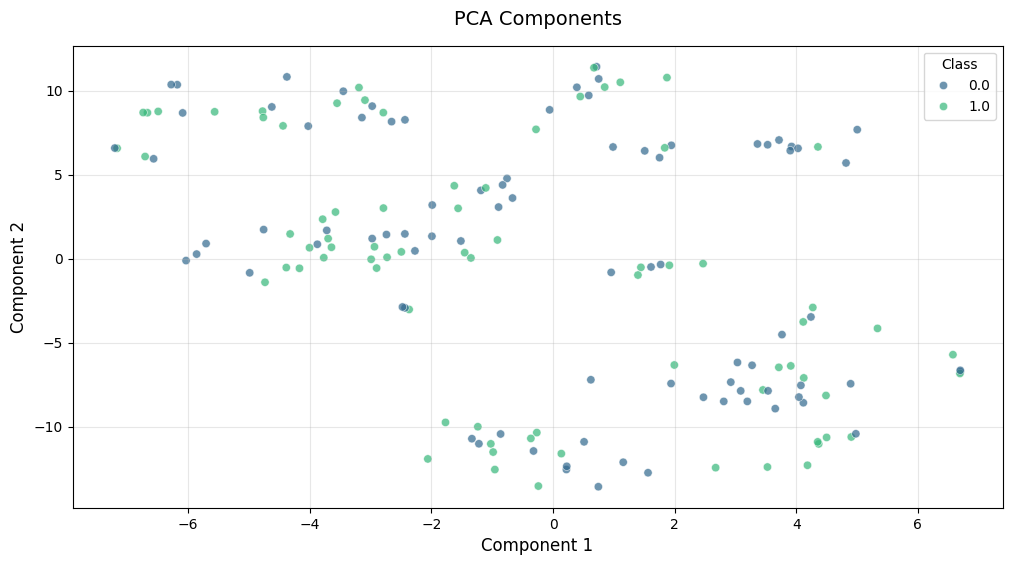

In [10]:
catch22_X_tsne = getTSNE(catch22.catch22_train, 2)
plot_components(catch22_X_tsne, y_train)

In [11]:
test = Morph(X_test, y_test)
test.get_DTWGlobalBorderline(50)

morphs, preds, results, metrics = test.Binay_MorphingCalculater(catch22, verbose=True)

Pair-Wise Results:
Pair: (15, 5) -> Morphing percentage: 0.09
Pair: (4, 16) -> Morphing percentage: 0.55
Pair: (15, 15) -> Morphing percentage: 0.39
Pair: (4, 11) -> Morphing percentage: 0.75
Pair: (8, 1) -> Morphing percentage: 0.25
Pair: (7, 22) -> Morphing percentage: 0.03
Pair: (10, 15) -> Morphing percentage: 0.12
Pair: (15, 17) -> Morphing percentage: 0.33
-------------------------------------------------
Mean morphing percentage: 0.31
Standard deviation of morphing percentage: 0.23
-------------------------------------------------
Correctly Classified Pairs: 8/50


In [12]:
test.plot_morph((4,9), morphs, preds)

Pair not found


### Loop Through Shift

In [13]:
# shift values = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]
shift_values = np.arange(0.5, -0.01, -0.05).tolist()

results = {}
for s in shift_values:
    # Generate dataset with shift
    gen = Generation(shift=s)
    X, y = gen.generate_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train models
    lstm = Models('lstm', X_train, y_train)
    lstm.train_lstm()
    catch22 = Models('catch22', X_train, y_train)
    catch22.train_catch22()
    rocket = Models('rocket', X_train, y_train)
    rocket.train_rocket()

    # Calculate morphing
    res = {}
    morph = Morph(X_test, y_test)
    morph.get_DTWGlobalBorderline(50) # 50 closer pairs from different classes

    res['lsmt'] = morph.Binay_MorphingCalculater(lstm)
    res['catch22'] = morph.Binay_MorphingCalculater(catch22)
    res['rocket'] = morph.Binay_MorphingCalculater(rocket)

    results[s] = res

d:\UNI\L_IACD\3_Year\2_Semester\INV\Morphing\generation.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sample_{i+1}'] = final_signal
d:\UNI\L_IACD\3_Year\2_Semester\INV\Morphing\generation.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sample_{i+1}'] = final_signal
d:\UNI\L_IACD\3_Year\2_Semester\INV\Morphing\generation.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

In [14]:
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [15]:
with open('results.pkl', 'rb') as f:
    loaded_res = pickle.load(f)

In [29]:
for key in loaded_res.keys():
    print(f"Shift Value: {key:.2f}")
    for model in loaded_res[key].keys():
        print('-------------------')
        print(f"Model: {model}")
        for m in loaded_res[key][model][3].keys():
            print(f"{m}: {loaded_res[key][model][3][m]:.2f}")
    print('-----------------------------------')
    

Shift Value: 0.50
-------------------
Model: lsmt
mean: 0.54
std: 0.13
-------------------
Model: catch22
mean: 0.17
std: 0.11
-------------------
Model: rocket
mean: 0.46
std: 0.03
-----------------------------------
Shift Value: 0.45
-------------------
Model: lsmt
mean: 0.62
std: 0.06
-------------------
Model: catch22
mean: 0.08
std: 0.05
-------------------
Model: rocket
mean: 0.43
std: 0.04
-----------------------------------
Shift Value: 0.40
-------------------
Model: lsmt
mean: 0.69
std: 0.09
-------------------
Model: catch22
mean: 0.12
std: 0.08
-------------------
Model: rocket
mean: 0.54
std: 0.06
-----------------------------------
Shift Value: 0.35
-------------------
Model: lsmt
mean: 0.75
std: 0.10
-------------------
Model: catch22
mean: 0.17
std: 0.13
-------------------
Model: rocket
mean: 0.46
std: 0.05
-----------------------------------
Shift Value: 0.30
-------------------
Model: lsmt
mean: 0.57
std: 0.15
-------------------
Model: catch22
mean: 0.24
std: 0.12
-